In [42]:
import sys
sys.path.append('..')
import h5py
import yaml
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('../utils/a4.mplstyle')

from ml_collections import config_dict
from pathlib import Path

import flowrec.data as data_utils
import flowrec.physics_and_derivatives as derivatives
import flowrec.training_and_states as state_utils
from flowrec import losses
from utils import simulation2d
from utils.py_helper import slice_from_tuple

In [7]:
# plt.figure()
# plt.plot(loss_good_mse[:,0],loss_good_mse[:,1],label='physics')
# plt.plot(loss_good_mse[:,0],loss_good_mse[:,2],label='sensors')
# plt.yscale('log')
# plt.legend()
# plt.show()

# Load data and model for evaluation

In [8]:
temp_results_dir = Path('../local_results/sweep_loss_3/denim-sweep-15/')
with open(Path(temp_results_dir,'config.yml'),'r') as f:
    cfg = yaml.load(f, Loader=yaml.UnsafeLoader)
    cfg.data_config.data_dir = '.'+cfg.data_config.data_dir

x_base = 132
triangle_base_coords = [49,80]
(ux,uy,pp) = simulation2d.read_data(cfg.data_config.data_dir,x_base)
x = np.stack([ux,uy,pp],axis=0)
# remove parts where uz is not zero
s = slice_from_tuple(cfg.data_config.slice_to_keep)
x = x[s]

[x_train,x_val,x_test], _ = data_utils.data_partition(x,
    1,
    cfg.data_config.train_test_split,
    REMOVE_MEAN=cfg.data_config.remove_mean,
    SHUFFLE=cfg.data_config.shuffle
) # Do not shuffle, do not remove mean for training with physics informed loss

[ux_train,uy_train,pp_train] = np.squeeze(np.split(x_train,3,axis=0))
[ux_val,uy_val,pp_val] = np.squeeze(np.split(x_val,3,axis=0))
[ux_test,uy_test,pp_test] = np.squeeze(np.split(x_test,3,axis=0))

datainfo = data_utils.DataMetadata(
    re = cfg.data_config.re,
    discretisation=[cfg.data_config.dt,cfg.data_config.dx,cfg.data_config.dy],
    axis_index=[0,1,2],
    problem_2d=True
).to_named_tuple()


Load runs summary

In [9]:
sweep_dir_3 = Path('../local_results/sweep_loss_3')
with h5py.File(Path(sweep_dir_3,'summary.h5'),'r') as hf:
    name_3 = np.array(hf.get('runs_name')).astype('unicode')
    loss_3 = np.array(hf.get('runs_loss'))


In [10]:
sweep_dir_classic = Path('../local_results/sweep_loss_classic')
with h5py.File(Path(sweep_dir_classic,'summary.h5'),'r') as hf:
    name_classic = np.array(hf.get('runs_name')).astype('unicode')
    loss_classic = np.array(hf.get('runs_loss'))


plot statistics

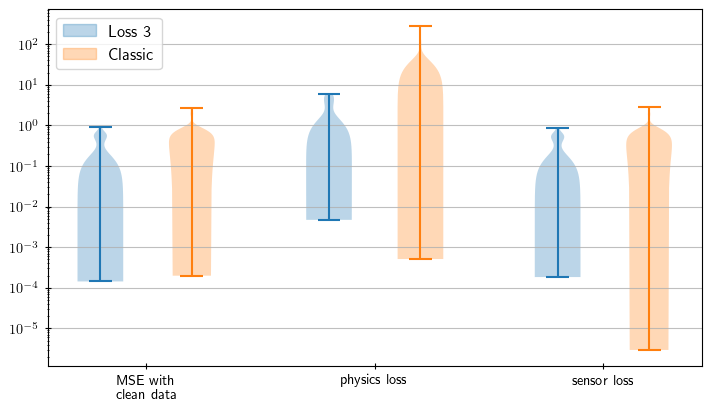

In [45]:
fig,ax = plt.subplots(1,1)
ax.set(yscale='log',xticks=[1,2,3],xticklabels=['MSE with \nclean data', 'physics loss','sensor loss'])
violin1 = ax.violinplot(loss_3,positions=[0.8,1.8,2.8],widths=0.2,)
violin2 = ax.violinplot(loss_classic,positions=[1.2,2.2,3.2],widths=0.2)
ax.grid(axis='y')

labels = []
color = violin1["bodies"][0].get_facecolor().flatten()
labels.append((matplotlib.patches.Patch(color=color), 'Loss 3'))
color = violin2["bodies"][0].get_facecolor().flatten()
labels.append((matplotlib.patches.Patch(color=color), 'Classic'))

plt.legend(*zip(*labels), loc=2)
plt.show()

# Verify results
Verify that the 'good' ones are good and 'bad' ones are bad

1. Compare robustness with respect to the range of hyperparameters

In [ ]:
import jax
import matplotlib.backends.backend_pdf
# pdf = matplotlib.backends.backend_pdf.PdfPages("test.pdf")

In [ ]:
for i in range(30):
    sweep_name = name_classic[i]
    results_dir = Path(sweep_dir_classic,sweep_name)
    with open(Path(temp_results_dir,'config.yml'),'r') as f:
        cfg = yaml.load(f, Loader=yaml.UnsafeLoader)

    ## normalise
    if cfg.data_config.normalise:
        [ux_train_normal,uy_train_normal,pp_train_normal], train_minmax = data_utils.normalise(ux_train,uy_train,pp_train)
        [ux_val_normal,uy_val_normal,pp_val_normal], val_minmax = data_utils.normalise(ux_val,uy_val,pp_val)
        [ux_test_normal,uy_test_normal,pp_test_normal], test_minmax = data_utils.normalise(ux_test,uy_test,pp_test)
        ## take input
        pb_train = simulation2d.take_measurement_base(pp_train_normal,ly=triangle_base_coords,centrex=0)
        pb_val = simulation2d.take_measurement_base(pp_val_normal,ly=triangle_base_coords,centrex=0)
        pb_test = simulation2d.take_measurement_base(pp_test_normal,ly=triangle_base_coords,centrex=0)
    else:
        ## take input
        pb_train = simulation2d.take_measurement_base(pp_train,ly=triangle_base_coords,centrex=0)
        pb_val = simulation2d.take_measurement_base(pp_val,ly=triangle_base_coords,centrex=0)
        pb_test = simulation2d.take_measurement_base(pp_test,ly=triangle_base_coords,centrex=0)

    pb_train = np.reshape(pb_train,(cfg.data_config.train_test_split[0],-1))
    pb_val = np.reshape(pb_val,(cfg.data_config.train_test_split[1],-1))
    pb_test = np.reshape(pb_test,(cfg.data_config.train_test_split[2],-1))

    u_train = np.stack((ux_train,uy_train,pp_train),axis=-1)
    u_val = np.stack((ux_val,uy_val,pp_val),axis=-1)
    u_test = np.stack((ux_test,uy_test,pp_test),axis=-1)


    state = state_utils.restore_trainingstate(results_dir,'state')
    _, make_model = cfg.case.select_model(datacfg=cfg.data_config, mdlcfg=cfg.model_config, traincfg=cfg.train_config)
    mdl = make_model(cfg.model_config)
    rng = jax.random.PRNGKey(10)
    pred_val = mdl.apply(state.params,rng,pb_val,TRAINING=False)
    if cfg.data_config.normalise:
        pred_val = data_utils.unnormalise_group(pred_val, train_minmax, axis_data=-1, axis_range=0)
    

    take_observation, _ = cfg.case.observe(cfg.data_config, example_pred_snapshot=u_val[0,...],example_pin_snapshot=pb_val[0,...])
    
    # l_s_val = losses.mse(take_observation(pred_val),take_observation(u_val))
    # l_d_val = np.mean(derivatives.div_field(pred_val[...,:-1],datainfo)**2)
    # l_m_val = np.mean(derivatives.momentum_residual_field(pred_val,datainfo)**2)
    # l_mse_clean = losses.mse(pred_val,u_val) 

    fig,ax = plt.subplots(1,3,figsize=(8,3))
    im1 = ax[0].imshow(pred_val[20,:,:,0],vmin=-0.6,vmax=1.8)
    plt.colorbar(im1,ax=ax[0])
    im2 = ax[1].imshow(pred_val[20,:,:,1],vmin=-1,vmax=1.5)
    plt.colorbar(im2,ax=ax[1])
    im3 = ax[2].imshow(pred_val[20,:,:,2],vmin=-1.5,vmax=0.25)
    plt.colorbar(im3,ax=ax[2])
    fig.suptitle(f'{sweep_name}:{l_mse_clean},mom:{l_m_val}')


fig_nums = plt.get_fignums()  
figs = [plt.figure(n) for n in fig_nums]
for fig in figs: ## will open an empty extra figure :(
    pdf.savefig(fig)
pdf.close()